### Introduction

This notebook aims to show my approach to create a function that can convert Pinyin(拼音) to Chinese sentences. Pinyin denotes the pronounciation of a Chinese word. The same Pinyin can map to different Chinese word. Also, it is possible that multiple Pinyin can map to the same Chinese word. 

### Problem

For a given sentence written in Pinyin, output the correct/meaningful Chinese sentence. 

For example: 

Input: 'ji qi xue xi shi dang xia fei chang huo re de ji shu'

Output: '机器学习是当下非常火热的技术'

### Methodology

Consider an input with n Pinyin (X_1, X_2, ... , X_n). Suppose for i_th Pinyin (X_i), it can map to M_i Chinese words. As a result, the total number of combination of Chinese words is M_1 * M_2 * M_3 * ... * M_n. 

In order to find the most prossible Chinese sentence, we should calculate the probability of each combination and then choose the combination of Chinese words (W_1, W_2, ... , W_n) such that the probability of the sentence is the highest. 

In order to make the calculation feasible for a large number of combination, we make the following assumption.

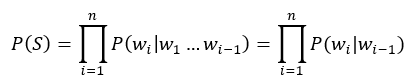

By counting the number of words in datasets, we can approximate the conditional probability.

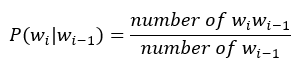

Before finding the sentence with highest probability, we first apply a simple algebraic trick so that we are doing summation when calculating. The following is the result.

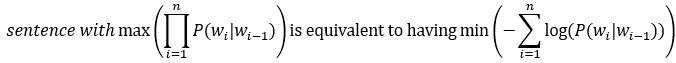

When the input is very long, the number of combination will be too large. In order to increase the efficiency, Veterbi algorithm can be applied to search for most possible combination. 

Denote C_ij as the j_th Chinese word candidate for i_th Pinyin, where j=1,2,3,…,M_i. We can apply the following recurrsive relation to find the most possible sentence. 

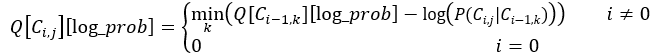

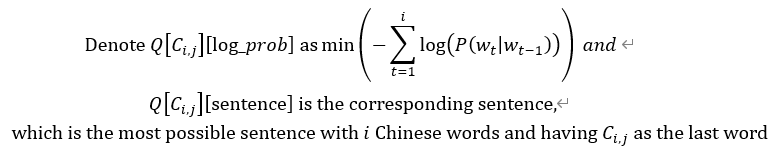

### Datasets

1. Sina News in Year 2016
2. Baike Q&A in Year 2018
3. Wiki Chinese articles

Source: https://github.com/brightmart/nlp_chinese_corpus

### Code

In [1]:
import glob
import json
import re
import pandas as pd
import numpy as np
from collections import defaultdict

### Create Dictionary to convert Pinyin to Chinese word 

In [2]:
txt_p2c = ''
with open(r'./data/拼音汉字表.txt', encoding='gbk') as f:
    for line in f.readlines():
        txt_p2c+=line
    
py2chi_dict = dict()
for py in txt_p2c.split('\n'):
    if py != '':
        py = py.split(' ')
        py2chi_dict[py[0]] = py[1:]


In [3]:
py2chi_dict['a']

['啊', '嗄', '腌', '吖', '阿', '锕']

### Create Dictionary to convert Chinese word to Pinyin 

In [4]:
multi_py = dict()  #多音字
chi2py_dict = dict()
for k,v in py2chi_dict.items():
    for word in v:
        if chi2py_dict.get(word, -1) == -1:
            chi2py_dict[word] = k
        else:
            if multi_py.get(word, -1) == -1:
                multi_py[word] = [chi2py_dict[word], k]
            else:
                multi_py[word].append(k)

In [5]:
chi2py_dict['拚']

'fan'

### Helper functions to preprocess the raw_data

In [6]:
# Convert year_number to Chinese
def year_to_chi(s):
    '''
    Convert year number to chinese.
    
    Parameters
    -----------
    s: re.Match
        Number in str form
        
    Returns
    ----------
    str
        str in Chinese word format
        
    Example
    ----------
    '2006年' -> '二零零六年'
    '''
    s = s.group()
    num_chi_map = {'0':'零','1':'一','2':'二','3':'三','4':'四','5':'五','6':'六','7':'七','8':'八','9':'九', '年':'年',
                   '０':'零','１':'一','２':'二','３':'三','４':'四','５':'五','６':'六','７':'七','８':'八','９':'九'}
    res = [num_chi_map.get(s[i], '') for i in range(len(s))]
    return ''.join(res)

In [7]:
# Convert number to Chinese
def num_to_chi(s):
    '''
    Convert number to chinese. Input should be an number less than 100000. Otherwise return empty string.
    
    Parameters
    -----------
    s: re.Match
        Number in str form
        
    Returns
    ----------
    str
        str in Chinese word format
        
    Example
    ----------
    '1006.706' -> '一千零六点七零六'
    '''
    s = s.group()
    res_int = ''
    res_decimal = ''
    num_chi_map = {'0':'零','1':'一','2':'二','3':'三','4':'四','5':'五','6':'六','7':'七','8':'八','9':'九',
                   '０':'零','１':'一','２':'二','３':'三','４':'四','５':'五','６':'六','７':'七','８':'八','９':'九'}
    if '.' not in s:
        integer = s
    else:
        s = s.split('.')
        integer = s[0]
        decimal = s[1]
        for i in decimal:
            res_decimal += num_chi_map[i]
        res_decimal = '点'+res_decimal
            
    l = len(integer)
    if l>5 or l==0:
        return ''
    units = list('万千百十 ')
    
    for i in list(range(l))[::-1]:
        num = num_chi_map.get(integer[i], -1)
        if num == -1:
            return ''
        unit = units.pop()
        if unit == ' ':
            if integer[i]!='0':
                res_int = num
        else:
            if integer[i] != '0':
                res_int = num+unit+res_int
            else:
                res_int = num+res_int
    while '零零' in res_int:
        res_int = res_int.replace('零零','零')

    return res_int+res_decimal

In [8]:
def preprocess_raw_text(text):
    '''
    Parameters
    -----------
    text: str
        Raw sentence from txt file
        
    Returns
    ----------
    List
        List of sentences
    '''
    # remove english characters
    eng_filter = re.compile('[A-Za-z]')
    text = eng_filter.sub('', text)
    # conver year_number to chinese word
    year_p = re.compile('\d{1,}年')
    text = year_p.sub(year_to_chi, text)
    # convert number to chinese word 
    num_p = re.compile('\d{1,}\.?\d*')    # number pattern
    text = num_p.sub(num_to_chi,text)
    # split the text into sentences by punctuation
    punctuation = re.compile('[!，?#：（）。《》、@……&“” ]')
    text = punctuation.split(text)
    return text

### Load the raw_data from sina_news

In [15]:
files = glob.glob(r'./data/raw_samples/sina_news/2016*')
sina_data = []
for file in files:
    with open(file, encoding='gbk') as f:
        sina_data.extend([json.loads(line) for line in f.readlines()])


In [16]:
sina_data[0]

{'html': '原标题：快讯：台湾高雄6.7级地震 多幢大楼倒塌 不断传出呼救声中国地震台网测定，今日3时57分在台湾高雄市发生6.7级地震。据台媒报道，地震释放能量相当于两颗原子弹。台南市多处楼房倾斜倒塌。其中，台南市永大路二段一栋住宅大楼倒塌，整栋建筑物倒榻在马路上，建筑物内不断传出呼救声。#高雄6.7级地震#',
 'time': '2016-02-06 06:45',
 'title': '快讯：台湾高雄6.7级地震 多幢大楼倒塌 不断传出呼救声',
 'url': 'http://news.sina.com.cn/o/2016-02-06/doc-ifxpfhzk9008548.shtml'}

In [17]:
# Join all html together
sina_data = [text['html'] for text in sina_data]
sina_data = ' '.join(sina_data)

In [18]:
# preprocess the raw_data
sina_data = preprocess_raw_text(sina_data)

In [19]:
# Save the preprocessed data
df_tmp = pd.DataFrame()
df_tmp['sample'] = sina_data
df_tmp = df_tmp[~df_tmp['sample'].isin([''])]
df_tmp.to_csv(r'./data/preprocessed_sina_news.csv', index=False, encoding='utf8')

In [6]:
df_tmp = pd.read_csv(r'./data/preprocessed_sina_news.csv')
df_tmp

,sample
0,原标题
1,快讯
2,台湾高雄六点七级地震
3,多幢大楼倒塌
4,不断传出呼救声中国地震台网测定
...,...
41389156,对供热单位处理结果有意见的
41389157,可拨打一万二千三百四十五热线电话进行投诉
41389158,编辑
41389159,戴玉玺


### Load the raw_data from Q&A_data_set

In [9]:
file = r'./data/raw_samples/baike_qa2019/baike_qa_train.json'
with open(file, encoding='utf8') as f:
    qa_data = [json.loads(line) for line in f.readlines()]

In [10]:
qa_data[0]

{'qid': 'qid_5982723620932473219',
 'category': '教育/科学-理工学科-地球科学',
 'title': '人站在地球上为什么没有头朝下的感觉 ',
 'desc': '',
 'answer': '地球上重力作用一直是指向球心的，因此\r\n只要头远离球心，人们就回感到头朝上。'}

In [11]:
# Join all text together
qa_data = [text['title']+' '+text['desc']+' '+text['answer'] for text in qa_data]
qa_data = ' '.join(qa_data)

In [14]:
# Preprocess raw data
qa_data = preprocess_raw_text(qa_data)

In [15]:
# Save the preprocessed data
df_tmp = pd.DataFrame()
df_tmp['sample'] = qa_data
df_tmp = df_tmp[~df_tmp['sample'].isin([''])]
df_tmp.to_csv(r'./data/preprocessed_qa.csv', index=False, encoding='utf8')

In [16]:
df_tmp

,sample
0,人站在地球上为什么没有头朝下的感觉
3,地球上重力作用一直是指向球心的
4,因此\r\n只要头远离球心
5,人们就回感到头朝上
7,我的小
...,...
56444773,羽族的还是要先打芝人再挖芝马
56444774,我练的妖精号也是要先打芝人再挖芝马
56444775,只不过两个族打的怪不一样
56444776,人族没练


### Load raw_data from wiki_data_set

In [9]:
wiki_data = []
folders = glob.glob(r'./data/raw_samples/wiki_zh_2019/wiki_zh/*')
all_files = []
for folder in folders:
    files = glob.glob(folder+'/*')
    all_files.extend(files)

for file in all_files:
    with open(file, encoding='utf8') as f:
        tmp = [json.loads(line) for line in f.readlines()]
        wiki_data.extend(tmp)
        

In [10]:
wiki_data[0]

{'id': '13',
 'url': 'https://zh.wikipedia.org/wiki?curid=13',
 'title': '数学',
 'text': '数学\n\n数学是利用符号语言研究数量、结构、变化以及空间等概念的一门学科，从某种角度看属于形式科学的一种。数学透过抽象化和逻辑推理的使用，由计数、计算、量度和对物体形状及运动的观察而产生。数学家们拓展这些概念，为了公式化新的猜想以及从选定的公理及定义中建立起严谨推导出的定理。\n\n基础数学的知识与运用总是个人与团体生活中不可或缺的一环。对数学基本概念的完善，早在古埃及、美索不达米亚及古印度内的古代数学文本便可观见，而在古希腊那里有更为严谨的处理。从那时开始，数学的发展便持续不断地小幅进展，至16世纪的文艺复兴时期，因为新的科学发现和数学革新两者的交互，致使数学的加速发展，直至今日。数学并成为许多国家及地区的教育范畴中的一部分。\n\n今日，数学使用在不同的领域中，包括科学、工程、医学、经济学和金融学等。数学对这些领域的应用通常被称为应用数学，有时亦会激起新的数学发现，并导致全新学科的发展，例如物理学的实质性发展中建立的某些理论激发数学家对于某些问题的不同角度的思考。数学家也研究纯数学，就是数学本身的实质性内容，而不以任何实际应用为目标。虽然许多研究以纯数学开始，但其过程中也发现许多应用之处。\n\n西方语言中“数学”（）一词源自于古希腊语的（），其有“学习”、“学问”、“科学”，以及另外还有个较狭义且技术性的意思－「数学研究」，即使在其语源内。其形容词（），意思为"和学习有关的"或"用功的"，亦会被用来指"数学的"。其在英语中表面上的复数形式，及在法语中的表面复数形式\'，可溯至拉丁文的中性复数\'，由西塞罗译自希腊文复数（），此一希腊语被亚里士多德拿来指「万物皆数」的概念。\n\n汉字表示的「数学」一词大约产生于中国宋元时期。多指象数之学，但有时也含有今天上的数学意义，例如，秦九韶的《数学九章》（《永乐大典》记，即《数书九章》也被宋代周密所著的《癸辛杂识》记为《数学大略》）、《数学通轨》（明代柯尚迁著）、《数学钥》（清代杜知耕著）、《数学拾遗》（清代丁取忠撰）。直到1939年，经过中国数学名词审查委员会研究“算学”与“数学”两词的使用状况后，确认以“数学”表示今天意义上的数学含义。\n

In [11]:
# Join all text together
wiki_data = [text['text'] for text in wiki_data]
wiki_data = ' '.join(wiki_data)

In [12]:
# Preprocess the raw data
wiki_data = preprocess_raw_text(wiki_data)

In [7]:
# Save the preprocessed data
df_tmp = pd.DataFrame()
df_tmp['sample'] = wiki_data
df_tmp = df_tmp[~df_tmp['sample'].isin([''])]
df_tmp.to_csv(r'./data/preprocessed_wiki.csv', index=False, encoding='utf8')

In [14]:
df_tmp

,sample
0,数学\n\n数学是利用符号语言研究数量
1,结构
2,变化以及空间等概念的一门学科
3,从某种角度看属于形式科学的一种
4,数学透过抽象化和逻辑推理的使用
...,...
41455235,人不断重新尝试出来的作品
41455236,希望可以感动众人；制作人也表示这首歌听起来非常有能量
41455237,跟影集本身的主轴非常契合
41455238,相信肯定能抓住观众的心


### Obtain the transition probability by counting number of words
To get P(W_{i}|W_{i-1})

In [6]:
def get_trans_prob(df_all, smoothing_coef=0.99, chi2py_dict=chi2py_dict):
    '''
    Parameters
    -----------
    df_all: pd.DataFrame
        The first column contains sentences from preprocessed data
    
    smoothing_coef: float
        Used in smoothing technique 
    
    chi2py_dict: dict
        Used to check that each word in data is within specified range
        
    Returns
    ----------
    pd.DataFrame
        The column is the previous word and the row is next word.
        i.e.: df[W_{i-1}][W_{i}] = P(W_{i}|W_{i-1})
    '''
    transition_count = defaultdict(lambda: defaultdict(lambda: 0))
    word_count = defaultdict(lambda: 0)
    for i in df_all.itertuples():
        prev = '^'  # marker for "start of sentence"
        word_count_flag = False  # determine if it is a valid sentence
        for word in i[1]:
            if word not in chi2py_dict:
                next
            else:
                word_count_flag = True
                word_count[word]+=1
                transition_count[prev][word]+=1
                prev = word
        if word_count_flag:
            word_count['^'] += 1

    df_trans = pd.DataFrame(transition_count)
    df_trans = df_trans.fillna(0)

    for col in df_trans.columns:
        df_trans[col] /= word_count[col]

    # smoothing
    smoothing_coef = 0.99
    total_words = 0
    for word, count in word_count.items():
        total_words+=count
    for idx in df_trans.index:
        df_trans.loc[idx] = df_trans.loc[idx]*smoothing_coef + word_count[idx]/total_words*(1-smoothing_coef)
    return df_trans



In [7]:
all_data = [r'./data/preprocessed_sina_news.csv', r'./data/preprocessed_qa.csv', r'./data/preprocessed_wiki.csv']
df_all = [pd.read_csv(data) for data in all_data]
df_all = pd.concat(df_all)
df_all

,sample
0,原标题
1,快讯
2,台湾高雄六点七级地震
3,多幢大楼倒塌
4,不断传出呼救声中国地震台网测定
...,...
36374078,人不断重新尝试出来的作品
36374079,希望可以感动众人；制作人也表示这首歌听起来非常有能量
36374080,跟影集本身的主轴非常契合
36374081,相信肯定能抓住观众的心


In [8]:
df_trans = get_trans_prob(df_all)
df_trans

,^,原,标,快,台,湾,高,雄,六,点,...,脎,弪,漤,铞,觫,蟓,镥,牿,軎,戤
原,6.111533e-03,3.489251e-04,2.338343e-04,8.467737e-05,4.448182e-04,4.392215e-03,6.412799e-03,4.819887e-04,6.892690e-05,3.400754e-04,...,1.329127e-05,1.329127e-05,1.329127e-05,1.329127e-05,1.329127e-05,1.329127e-05,1.065845e-02,1.329127e-05,1.329127e-05,1.329127e-05
快,4.560288e-04,4.166830e-05,5.713309e-05,5.503386e-03,1.473228e-04,8.118875e-05,1.879779e-04,2.025450e-04,4.395912e-05,1.929529e-04,...,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06,5.198753e-06
台,1.207024e-03,5.037636e-04,7.004511e-05,3.068108e-05,1.134022e-03,1.495894e-02,6.832106e-04,3.063045e-04,5.700692e-04,7.099904e-05,...,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05,1.028505e-05
多,2.054530e-03,1.447385e-04,2.360841e-04,1.038730e-03,5.785080e-04,1.056827e-03,4.779380e-04,7.600940e-04,1.377474e-04,4.108335e-03,...,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05,2.621247e-05
不,1.154378e-02,4.619079e-04,3.158168e-03,2.208659e-03,1.610589e-03,1.472351e-03,2.955429e-03,3.702734e-03,4.093138e-04,5.741685e-03,...,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05,6.416188e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
唣,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,...,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11,5.355249e-11
瘃,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,...,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11,2.295107e-11
觫,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,...,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,8.250000e-02,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11,9.180427e-11
哜,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,...,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12,7.650355e-12


In [9]:
# Save the df_trans
df_trans.to_csv(r'./data/trans_matrix.csv', encoding='utf8')

In [6]:
# Read the df_trans
df_trans = pd.read_csv(r'./data/trans_matrix.csv', index_col =0)

### Find max likelihood sentences from pinyin

In [7]:
def get_trans_prob(prev, cur, df_trans):
    try:
        res = df_trans[prev][cur]
    except:
        res = 10e-15
    return res

In [8]:
def to_chi_sentence(py, df_trans):
    '''
    Parameters
    -----------
    py: str
        Sentence in Pingyin. Each word is separated by a space.
        
    Returns
    ----------
    Str
        Most likely Chinese sentence
    '''
    py_l = py.split(' ')
    dp = defaultdict(lambda: defaultdict(lambda: {'likelihood':0, 'sentence':''}))
    for idx, word in enumerate(py_l):
        chi_candidates = py2chi_dict[word]
        if idx == 0:
            for chi_candidate in chi_candidates:
                trans_p = get_trans_prob('^',chi_candidate, df_trans)
                dp[idx][chi_candidate]['likelihood'] += -np.log(trans_p)
                dp[idx][chi_candidate]['sentence'] += chi_candidate
        else:
            for chi_candidate in chi_candidates:
                min_likelihood = None
                min_sentence = None
                for prev_word, prev_word_record in dp[idx-1].items():
                    trans_p = get_trans_prob(prev_word,chi_candidate, df_trans)
                    cur_likelihood = prev_word_record['likelihood'] - np.log(trans_p)
                    if min_likelihood is None or cur_likelihood <= min_likelihood:
                        min_likelihood = cur_likelihood
                        min_sentence = prev_word_record['sentence'] + chi_candidate
                dp[idx][chi_candidate]['likelihood'] = min_likelihood
                dp[idx][chi_candidate]['sentence'] = min_sentence
    l = len(py_l)
    min_res_likelihood = None
    min_res_senetence = None
    for last_word, last_word_record in dp[l-1].items():
        cur_likelihood = last_word_record['likelihood']
        if min_res_likelihood is None or cur_likelihood <= min_res_likelihood:
            min_res_likelihood = cur_likelihood
            min_res_senetence = last_word_record['sentence']
    return min_res_senetence

In [9]:
to_chi_sentence('chuang qian ming yue guang', df_trans)

'窗前明月光'

In [11]:
# Test to_chi_senetence function
s = 'ai yin si tan ti chu le guang yi xiang dui lun'
print('Whole sentence: ', to_chi_sentence(s, df_trans))

word_by_word = [to_chi_sentence(i, df_trans) for i in s.split(' ')]
print('Word by word: ', ''.join(word_by_word))

Whole sentence:  爱因斯坦提出了广义相对论
Word by word:  爱因四探提出了广一相对论


### Make the prediction

In [21]:
# Load the test sample inputs
x_test_file = './data/test_samples/input-0315update.txt'
with open(x_test_file, encoding='utf8') as f:
    x_test = [line.strip() for line in f.readlines()]
print(x_test[0])
        

bei jing shi shou ge ju ban guo xia ao hui yu dong ao hui de cheng shi


In [22]:
# Load the test sample outputs
y_test_file = './data/test_samples/std_output.txt'
with open(y_test_file, encoding='utf8') as f:
    y_test = [line.strip() for line in f.readlines()]
print(y_test[0])

北京是首个举办过夏奥会与冬奥会的城市


In [23]:
# Use test sample input to generate predicted senetences
pred = [to_chi_sentence(i, df_trans) for i in x_test]
print(pred[0])

北京市首个举办过下奥会于冬奥会的城市


In [38]:
# save output as txt
with open('./data/output.txt', 'w', encoding = 'utf8') as f:
    s = '\n'.join(pred)
    f.write(s)

### Evaluate the result

In [31]:
# Calculate acc of sentences
correct = 0
for idx, row in df_pred.iterrows():
    if row['std_output'] == row['prediction']:
        correct += 1
print('Sentence Accuracy: ', correct/len(df_pred))

Sentence Accuracy:  0.39


In [33]:
# Calculate acc of words
total_word = 0
corr_word = 0
for idx, row in df_pred.iterrows():
    for idx2, word in enumerate(row['std_output']):
        total_word += 1
        if word == row['prediction'][idx2]:
            corr_word += 1
print('Word Accuracy: ', corr_word/total_word)

Word Accuracy:  0.8420952016822787


In [40]:
# Calculate acc of words for each sentence
sentence_acc = []
for idx, row in df_pred.iterrows():
    total_word = 0
    corr_word = 0
    for idx2, word in enumerate(row['std_output']):
        total_word += 1
        if word == row['prediction'][idx2]:
            corr_word += 1
    sentence_acc.append(corr_word/total_word)


In [42]:
# Save the predicted sentences
df_pred = pd.DataFrame({'input':x_test, 'std_output':y_test, 'prediction':pred, 'sentence_accuracy':sentence_acc})
df_pred.to_csv('./data/test_pred.csv', index=False)
df_pred.to_excel('./data/test_pred.xlsx', index=False)

<AxesSubplot:>

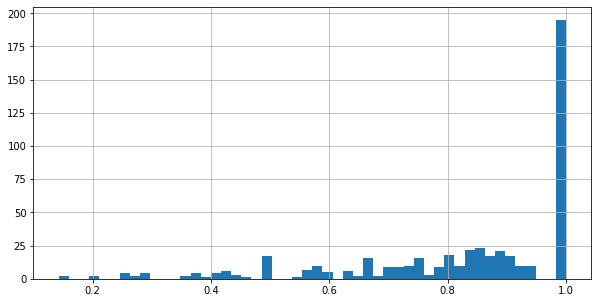

In [75]:
# Visualized distribution of the word accuracy of output sentences
df_pred['sentence_accuracy'].hist(bins=50, figsize=(10,5))

From the figure above, we can see that the accuracy of output sentences is quite high. On average, each output sentence has over 80% of correct words. However, when input the conversations in novels, the output sentences have a relatively low accuracy. This is because the training data set are mainly from news, wiki, and Q&A text. Hence, including more dataset to calculate the transition frequency should imporve the result.